# 03 :: CUR column subset selection

In [33]:
import pandas as pd
import numpy as np
import os

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

# Commonly used constants.

slides = [
    'B02_D1', 'B02_E1', 'B03_C2', 'B03_D2', 'B04_D1',
    'B04_E1', 'B05_D2', 'B05_E2', 'B06_E1', 'B07_C2',
    'N02_C1', 'N02_D1', 'N03_C2', 'N03_D2', 'N04_D1',
    'N04_E1', 'N05_C2', 'N05_D2', 'N06_D2', 'N07_C1']

In [34]:
lcpm_parquet   = '/media/tmo/data/work/datasets/02_ST/lcpm/lcpm.parquet'
meta_parquet   = '/media/tmo/data/work/datasets/02_ST/meta/meta.parquet'

In [35]:
%%time
lcpm_df = pd.read_parquet(lcpm_parquet)
meta_df = pd.read_parquet(meta_parquet)
    
st_df = lcpm_df.merge(meta_df, how='inner', on='spot_UID')

CPU times: user 10.3 s, sys: 29.2 s, total: 39.5 s
Wall time: 13 s


In [36]:
st_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10327 entries, 0 to 10326
Columns: 46763 entries, spot_UID to age_gt
dtypes: float64(46688), int64(65), object(10)
memory usage: 3.6+ GB


In [37]:
st_df.head()

,spot_UID,-343C11.2,00R_AC107638.2,0610005C13Rik,0610006L08Rik,0610007P14Rik,0610009B22Rik,0610009E02Rik,0610009L18Rik,0610009O20Rik,...,endothelial,interneuron,slide_ID_y,region,sampleID_y,GT,age_days,age_months,age,age_gt
0,N05_C2__20_6,0.0,0.0,0.0,0.0,0.000000,0.000000,4.570584,0.0,0.000000,...,0.095625,0.106595,N05_C2,AT_OLF,N05_C2,KI,558,18,old,old_KI
1,N05_C2__17_6,0.0,0.0,0.0,0.0,6.722953,5.722953,0.000000,0.0,0.000000,...,-0.014931,0.049969,N05_C2,AT_OLF,N05_C2,KI,558,18,old,old_KI
2,N05_C2__16_6,0.0,0.0,0.0,0.0,0.000000,5.354258,0.000000,0.0,5.354258,...,-0.049142,-0.042531,N05_C2,AT_OLF,N05_C2,KI,558,18,old,old_KI
3,N05_C2__19_6,0.0,0.0,0.0,0.0,7.603936,0.000000,0.000000,0.0,4.796581,...,0.057104,0.143494,N05_C2,AT_OLF,N05_C2,KI,558,18,old,old_KI
4,N05_C2__18_6,0.0,0.0,0.0,0.0,6.628026,6.628026,0.000000,0.0,0.000000,...,0.043532,0.098493,N05_C2,AT_OLF,N05_C2,KI,558,18,old,old_KI


---

# Compute Leverage Scores

In [13]:
gene_columns = lcpm_df.columns[1:-1]

In [14]:
ex_matrix = lcpm_df[gene_columns].as_matrix()

In [15]:
ex_matrix.shape

(10327, 46454)

In [16]:
from scipy.linalg import svd

In [17]:
%%time
U, s, V = svd(ex_matrix)

CPU times: user 2h 37min 14s, sys: 37min 31s, total: 3h 14min 45s
Wall time: 5min 18s


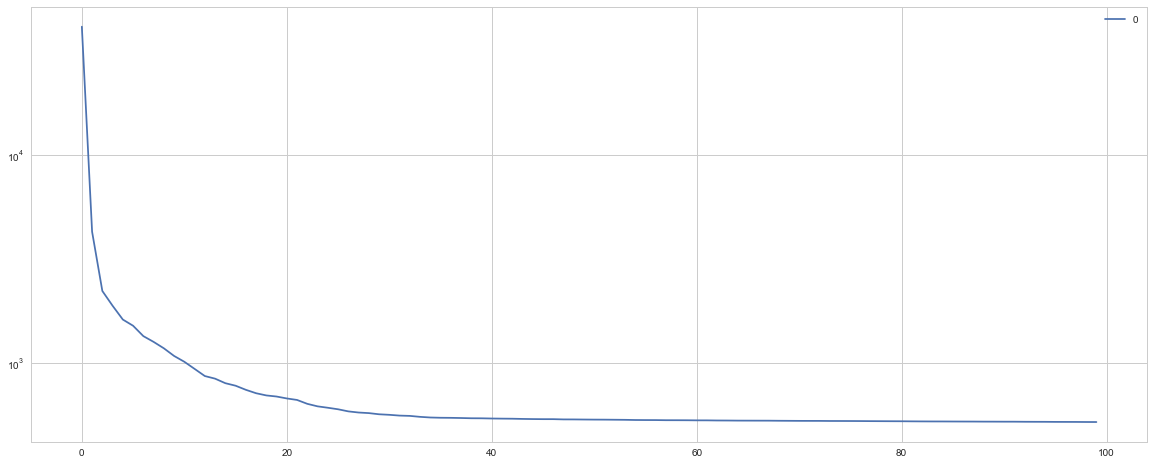

In [18]:
pd.DataFrame(s[:100]).plot(logy=True, figsize=(20,8))
plt.show()

In [38]:
row_k = 60
col_k = 60  # guess based on the plot above

def to_lev_df(lev_values):
    return pd.DataFrame(lev_values, columns=['leverage'])

def to_row_lev_scores(U, k):
    row_lev_values = np.sum(U[:,:k]**2, axis=1)
    
    return to_lev_df(row_lev_values)    

def to_col_lev_scores(V, k):
    col_lev_values = np.sum(V[:k,:]**2,axis=0)
    
    return to_lev_df(col_lev_values)

In [39]:
row_lev_df = to_row_lev_scores(U, row_k)
col_lev_df = to_col_lev_scores(V, col_k)

col_lev_stats = col_lev_df.describe()
col_lev_min = col_lev_stats.loc['min'][0]
col_lev_std = col_lev_stats.loc['std'][0]

In [40]:
ranked_gene_lev_df = pd.DataFrame(gene_columns) \
    .merge(col_lev_df.sort_values(by='leverage', ascending=False), 
           left_index=True, 
           right_index=True) \
    .sort_values(by='leverage', ascending=False)
    
ranked_gene_lev_df.columns = ['gene', 'leverage']    

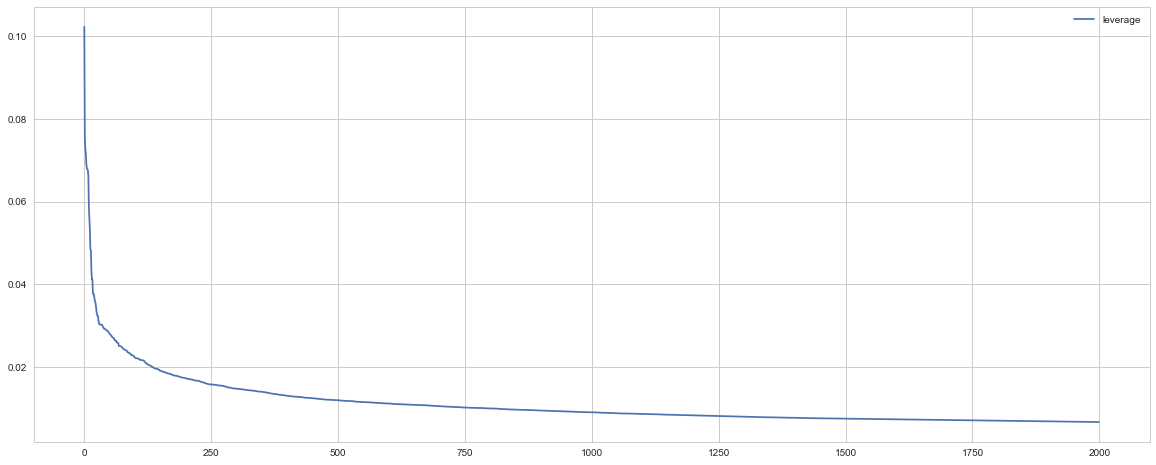

In [41]:
ranked_gene_lev_df.sort_values(by='leverage', ascending=False)[:2000].plot(figsize=(20,8), use_index=False)
plt.show()

In [42]:
ranked_gene_lev_df.to_csv('ranked_gene_leverage.tsv', sep='\t')

In [43]:
ranked_gene_lev_df.head(50)

,gene,leverage
28690,Hba-a1,0.102326
36385,Pmch,0.075799
41397,Slc46a3,0.072592
28698,Hbb-bt,0.071700
8823,Fzd5,0.069134
46282,mt-Atp8,0.068017
869,2810433D01Rik,0.067860
28691,Hba-a2,0.067581
30298,Kif15,0.066238
42744,Tbx1,0.058639
